In [1]:
"""
Sliding and Hopping on DNA.

This is a python script that analyses the position of a protein relative to the DNA axis to understand, 
if the protein is either in free or 1-dimensional diffusion and if this 1-dimensional diffusion 
is sliding or hopping. It contains packages for reading in data, sorting the frames according to 
1D- and 3D-diffusion in the first instance and sliding and hopping in the second instance, as well as packages 
that analyse dimeric DNA-binding proteins for symmetric and asymmetric sliding and flipping. Further packages 
measure the time and crossed distances in different diffusional states, and take care of plotting or 
statistical analysis.

The input is a csv file that contains the distance from the DNA, the position along the DNA axis
and the angle relative to the DNA-axis (z-axis of the coordinate system) and the x-axis of the 
coordinate system.

"""

'\nSliding and Hopping on DNA.\n\nThis is a python script that analyses the position of a protein relative to the DNA axis to understand, \nif the protein is either in free or 1-dimensional diffusion and if this 1-dimensional diffusion \nis sliding or hopping. It contains packages for reading in data, sorting the frames according to \n1D- and 3D-diffusion in the first instance and sliding and hopping in the second instance, as well as packages \nthat analyse dimeric DNA-binding proteins for symmetric and asymmetric sliding and flipping. Further packages \nmeasure the time and crossed distances in different diffusional states, and take care of plotting or \nstatistical analysis.\n\nThe input is a csv file that contains the distance from the DNA, the position along the DNA axis\nand the angle relative to the DNA-axis (z-axis of the coordinate system) and the x-axis of the \ncoordinate system.\n\n'

In [2]:
import matplotlib.pyplot as plt
import glob
import sys
import pandas as pd
import numpy as np
import sortednp as snp
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from matplotlib import rc
rc('font', family='helvetica')
import seaborn as sns
import time
import itertools

In [3]:
import sqlite3

In [4]:
"Some colorbrewer colors you can use."
p1 = np.array([224/256, 236/256, 244/256, 1])
p2 = np.array([158/256, 160/256, 218/256, 1])
p3 = np.array([136/256, 86/256, 167/256, 1])
g1 = np.array([229/256, 245/256, 249/256, 1])
g2 = np.array([153/256, 216/256, 201/256, 1])
g3 = np.array([44/256, 162/256, 95/256, 1])
o1 = np.array([254/256, 232/256, 200/256, 1])
o2 = np.array([253/256, 187/256, 132/256, 1])
o3 = np.array([227/256, 74/256, 51/256, 1])

In [5]:
"""Define the folders with your input data."""
monomer='/Users/mallu899/Mirror/projects/lacI_CG_master/data/Mono_txt_20/'
dimer='/Users/mallu899/Mirror/projects/lacI_CG_master/data/dimer_RS_txt/'
full_dimer='/Users/mallu899/Mirror/projects/lacI_CG_master/data/fullLength_txt/trajectory_classify_diffusion/'

In [15]:
def import_displacement_csv_as_dataframe(file, nframes):
    """
    Import data from the displacement trajectory analysis.

    Parameter
    ---------
        file : str
            The folder location with the trajectory analysis output files containing distance,
            position and angle of the protein region of interetst relative to the DNA axis.
        nrows : int
            The number rows in the dataframe.

    Returns
    -------
        A pandas DataFrame table with columns
               'distance' (Å) ,'position' (Å),'angle' (degrees).
    """
    
    data = np.array(pd.read_csv(file,sep='\s+',header=None,nrows=nframes))
    
    d = {'distance': data[:,1],
        'position': data[:,0],
        'angle': data[:,2]*(180/np.pi)} #angle from radians to degrees
    dataframe=pd.DataFrame(d)
    #print(dataframe)
    return (dataframe)

class TrajectoryToDataFrame():
    """
    Class that obtains the analysis of the protein, either monomeric or dimeric, 
    in form of a pandas Dataframe 
    or a list of Dataframes for DNA-binding domains A and B in a dimer.
    
    Methods
    -------
    dimer(folder,nframes=100000)
        Analysis for dimeric DNA-binding proteins.
        
    monomer(folder,nframes=100000)
        Analysis for monomeric DNA-binding proteins.
        
    """
    
    def dimer(folder,nframes=100000):
        """Import data from the displacement trajectory analysis.

        Parameter
        ---------
            folder (str): The folder location with the displacement
                          trajectory analysis output files.
            nframes (int): number of rows to import

        Returns
        -------
            tuple: .
                   Each element in a list is a DataFrame table with columns
                   'distance','position','angle'.
                   two lists corresponding to the A and B proteins
        """

        filesA = sorted(glob.glob(folder+'*Displacement_H2A.txt'))
        filesB = sorted(glob.glob(folder+'*Displacement_H2B.txt'))
        if len(filesA) != len(filesB):
            raise ImportError('Number of files for A and B must be the same')
        dataframes = []
        files = (filesA,filesB)
        for i in range(2):
            dataframes_ = []
            for file in files[i]:
                dataframes_.append(import_displacement_csv_as_dataframe(file,nframes))
            dataframes.append(dataframes_)

        return tuple(dataframes)
    
    def monomer(folder,nframes=100000):
        """Import data from the displacement trajectory analysis for the monomer.
        
        Parameter
        ---------
            folder (str): The folder location with the displacement
                          trajectory analysis output files named as
                          '*Displacement_*.txt' 
            nframes (int): number of rows to import

        Returns
        -------
            tuple: .
                   Each element in a list is a DataFrame table with columns
                   'distance','position','angle'.
                   two lists corresponding to the A and B proteins
        """

        files = sorted(glob.glob(folder+'*Displacement_*.txt'))

        dataframes = []
        files = files
        for file in files:
            dataframes.append(import_displacement_csv_as_dataframe(file,nframes))

        return tuple(dataframes)

In [16]:
monomerS001=TrajectoryToDataFrame.monomer(monomer+'S01/')
monomerS002=TrajectoryToDataFrame.monomer(monomer+'S02/')
monomerS003=TrajectoryToDataFrame.monomer(monomer+'S03/')
monomerS004=TrajectoryToDataFrame.monomer(monomer+'S04/')

monomerR001=TrajectoryToDataFrame.monomer(monomer+'R01/')
monomerR002=TrajectoryToDataFrame.monomer(monomer+'R02/')
monomerR003=TrajectoryToDataFrame.monomer(monomer+'R03/')
monomerR004=TrajectoryToDataFrame.monomer(monomer+'R04/')

dimerS001=TrajectoryToDataFrame.dimer(dimer+'S/001/')
dimerS002=TrajectoryToDataFrame.dimer(dimer+'S/002/')
dimerS003=TrajectoryToDataFrame.dimer(dimer+'S/003/')
dimerS004=TrajectoryToDataFrame.dimer(dimer+'S/004/')
dimerS005=TrajectoryToDataFrame.dimer(dimer+'S/005/')
dimerS006=TrajectoryToDataFrame.dimer(dimer+'S/006/')

dimerR001=TrajectoryToDataFrame.dimer(dimer+'R/001/')
dimerR002=TrajectoryToDataFrame.dimer(dimer+'R/002/')
dimerR003=TrajectoryToDataFrame.dimer(dimer+'R/003/')
dimerR004=TrajectoryToDataFrame.dimer(dimer+'R/004/')
dimerR005=TrajectoryToDataFrame.dimer(dimer+'R/005/')
dimerR006=TrajectoryToDataFrame.dimer(dimer+'R/006/')

full_dimerR001=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/01/')
full_dimerR002=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/02/')
full_dimerR003=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/03/')
full_dimerR004=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/04/')
full_dimerR005=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/05/')
full_dimerR006=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/06/')

full_dimerS001=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/01/')
full_dimerS002=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/02/')
full_dimerS003=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/03/')
full_dimerS004=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/04/')
full_dimerS005=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/05/')
full_dimerS006=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/06/')

In [12]:
class Grooves():  
    """This class contains functions that relate the position and the angle 
     along the major grooves center in the static, generic B-DNA. 
     The groove-functions are a reference frame used to identify sliding.
     
    Methods
    ----------
    f0-f9: int 
         return the angle in degrees for a position in Å.
    f0y-f9y: int 
         return the position for an angle.
    groove_functions_angle
        return list(f0-f9)
    groove_functions_position
        return list(f0y-f9y)
    ____________________________________________________________________________
    f0p-f9p: int 
         return the angle in radians for a position in bp, for better plotting.
    f0y-f9y: int 
         return the position for an angle.
    groove_functions_angle_plotting
        return list(f0p-f9p)
    groove_functions_position_plotting
        return list(f0yp-f9yp)
    
    Usage
    -----
    Grooves.groove_functions()[0](3) returns f0(3)
    
    """
    
    def f0(x):
        return (x*9.78636231)-1410.46658798
    def f0y(y):
        return (y-(-1410.46658798))/9.78636231
    def f1(x):
        return (x*10.43608208)-1157.42910297
    def f1y(y):
        return (y-(-1157.42910297))/10.43608208
    def f2(x):
        return (x*10.43608208)-805.4409265
    def f2y(y):
        return (y-(-805.4409265))/10.43608208
    def f3(x):
        return (x*10.43608208)-453.45275003
    def f3y(y):
        return (y-(-453.45275003))/10.43608208
    def f4(x):
        return (x*10.43608208)-101.46457357
    def f4y(y):
        return (y-(-101.46457357))/10.43608208
    def f5(x):
        return (x*10.43608208)+250.5236029
    def f5y(y):
        return (y-(250.5236029))/10.43608208
    def f6(x):
        return (x*10.43608208)+602.51177936
    def f6y(y):
        return (y-(602.51177936))/10.43608208
    def f7(x):
        return (x*10.43608208)+954.49995583
    def f7y(y):
        return (y-(954.49995583))/10.43608208
    def f8(x):
        return (x*10.43608208)+1306.48813229
    def f8y(y):
        return (y-(1306.48813229))/10.43608208
    def f9(x):
        return (x*10.43608208)+1658.47630876
    def f9y(y):
        return (y-(1658.47630876))/10.43608208
    
    def groove_functions_angle():
        "Functions that obtain the angle for a position."
        return(Grooves.f0,Grooves.f1,Grooves.f2,Grooves.f3,Grooves.f4,Grooves.f5,Grooves.f6,Grooves.f7,Grooves.f8,Grooves.f9)
    
    def groove_functions_position():
        "Functions that obtain the value of position for one angle."
        return(Grooves.f0y,Grooves.f1y,Grooves.f2y,Grooves.f3y,Grooves.f4y,Grooves.f5y,Grooves.f6y,Grooves.f7y,Grooves.f8y,Grooves.f9y)

In [13]:
class ClassifyTrajectory:
    """Keeps only frames of 1D diffusion from the dataframe containing distance, position and angle
    and identifies sliding if check_sliding is called.
    
    Dependencies
    ------------
    Relies on class grooves to identify sliding.
    
    Methods
    -------
    check_dissociation(self, distance_threshold = 32.0)
        Sorts out 3D diffusion according to the distance threshold and
        replaces the distance column with indexes. 
        
    check_sliding(self,angle_cut_off= 34.0)
        Assigned the protein to the groove_indexes defined in Grooves.groove_functions and assignes 0 for hopping.
        This function calls check_dissociation in the first place.
        
    check_sliding_dimer(self,angle_cut_off= 34.0)
        Does the analysis for dimers.
        """
    
    def __init__(self,distance_position_angle_df):
        """
        Parameters
        ----------
        distance_position_angle_df : pd.DataFrame
            The dataframe with distance, position and angle.
        """
        
        self.distance_position_angle_df=distance_position_angle_df

        
    def __getitem__(self, position):
        """
        Returns
        -------
        One replica at a time."""
        
        return(self[position])
    
    def check_dissociation(self, distance_threshold = 32.0):
        """Function that checks if the protein is further away than a distance_threshold in Å from the DNA axis, 
        where the electrostatic interaction energy drops to less than 10%.
        
        Returns
        -------
        DataFrame with index, position and angle.
        """
        
        dfs=[]
        for df in self:
            df=df[df['distance'] < distance_threshold]
            df=df.reset_index()
            df.drop(columns='distance',inplace=True)
            dfs.append(df)

        return(dfs)
    
    def check_sliding(self,angle_cut_off= 51.0): #1.5 bp
        """Function that checks if the protein is in the groove that is defined by 10 groove_functions
        for the 100 bp generic B-DNA. 
        
        The protein has to be aligned with the center of the groove and can deviate from the angle of 
        the groove center by angle_cut_off degrees.
        
        It calls ClassifyTrajectory.check_dissociation(self) first to obtain only 1D diffusion.
        
        Returns
        -------
        DataFrame with index, position, angle and groove_index, which is 0 if the protein is not in the groove.
        """
        
        dfs=ClassifyTrajectory.check_dissociation(self)
        # Hardcoded parameters
        ZMIN = [145.0, 111.0, 78.0, 44.0, 10.0, -24.0, -57.0, -91.0, -125.0, -159.0]
        ZMAX = [181.0, 145.0, 111.0, 78.0, 44.0, 10.0, -24.0, -57.0, -91.0, -125.0]
          
        dfs_sliding=[]
        groove_indexes=range(1,11)
        groove_function_indexes=range(10)
        for df in dfs:
            df['groove_index']=np.zeros(len(df),dtype=int)
            for j in groove_function_indexes:
                #Check in which groove area the protein is. You get the indexes where a particular j will match.
                ind = df.index[((df['position']>= ZMIN[j]) & (df['position'] <ZMAX[j])) ]
                #get the angle of this groove from the functions
                groove_angle = Grooves.groove_functions_angle()[j](df['position'][ind])
                #and check if the angle in this position is close
                ind2 = ind[np.abs(groove_angle-df['angle'][ind]) <= angle_cut_off]
                df.loc[ind2,'groove_index']=groove_indexes[j]
            dfs_sliding.append(df)
        return(dfs_sliding)
    
    def check_sliding_dimer(self):
        """Obtains indexes, position, angle and groove_indexes for the two DBDs in a dimeric protein."""
        
        dfA=ClassifyTrajectory.check_sliding(self[0])
        dfB=ClassifyTrajectory.check_sliding(self[1])
        return(dfA,dfB)
        

In [17]:
#tstIndPosAngGroove=ClassifyTrajectory.check_sliding_dimer(TrajectoryToDataFrame.dimer('/Users/mallu899/Documents/projects/lacI_CG_master/data/dimer_RS_txt/S/001/'))
tstIndPosAngGroove=ClassifyTrajectory.check_sliding_dimer(full_dimerS001)

In [18]:
def smoothen_sliding_vs_hopping(dataframe):
    data_add_slide_start_end=np.append(np.append(1,dataframe['groove_index_bin']),1)
    diff_data = np.diff(data_add_slide_start_end)
    (hop_starts,) = np.where(diff_data==-1)
    (hop_ends,) = np.where(diff_data==1)
    hop_lens = hop_ends-hop_starts
    
    dataframe_1=dataframe['groove_index_bin'].copy()
    for i in range(len(hop_lens)):
        if hop_lens[i] < 10:
            dataframe_1.iloc[hop_starts[i]:hop_ends[i]] = 1
    
    data_add_slide_start_end=np.append(np.append(1,dataframe_1),1)
    diff_data=np.diff(data_add_slide_start_end)
    (slide_starts,) = np.where(diff_data==1)
    (slide_ends,) = np.where(diff_data==-1)
    slide_lens = slide_ends-slide_starts
    
    dataframe_new=dataframe_1.copy()
    for i in range(len(slide_lens)):
        if slide_lens[i] < 10:
            dataframe_new.iloc[slide_starts[i]:slide_ends[i]] = 0
    return(dataframe_new)

In [19]:
def window_fun(x):
    """
    Checks that there are 1s both to the left and to the right from a frame in a given window.
    
    Example 
    -------
    for usage on a pandas DataFrame, df:
    df_new = df.rolling(window,center=True).apply(window_fun,raw=True)
    """
    
    half = len(x)//2
    return 1.0 if (x[half]==1.0) | ( (np.any(x[0:half]) & (np.any(x[half+1::])) ) ) else 0.0

def window_fun_sum(x):
    """
    Checks that there are 1s both to the left and to the right from a frame in a given window.
    
    Example 
    -------
    for usage on a pandas DataFrame, df:
    df_new = df.rolling(window,center=True).apply(window_fun,raw=True)
    """
    
    half = len(x)//2
    return 1.0 if (np.sum(x)>=float(half)) else 0.0

def start_end_dataframe(start_df,end_df,protein_descriptor,replica):
    """Function that transfers dataframes with start and end frames and positions into one dataframe.
    
    Parameters
    ----------
    start_df: Pandas DataFrame
    end_df: Pandas DataFrame
    protein_descriptor: str
    replica: str
    
    Returns
    -------
    A pandas DataFrame containing start- and end-frames and -positions as well as a protein descriptor 
    and the replica record.
    """
    
    #print(start_df,end_df)
    assert len(start_df)==len(end_df), 'Number of start and end frames must be the same'
    
    data={'start_frame':[int(x) for x in start_df['frame'] ],
          'end_frame':[int(x) for x in end_df['frame']],
          'start_position':[float(x) for x in start_df['position'] ],
          'end_position':[float(x) for x in end_df['position']],
          'protein':[protein_descriptor for x in start_df.index],
          'replica':[replica for x in start_df.index]}
    
    df=pd.DataFrame(data)
    return(df)

def get_start_end_sliding(D1_diffusion_dataFrame,rolling_window,protein_descriptor,replica):
    """
    Split 1D diffusion in intervalls of sliding and hopping.
    
    Parameters
    ----------
    D1_diffusion_dataFrame : pandas DataFrame
        Contains frame, position, angle and groove_index. The length is minimal 100 frames (rows).
    rolling_window: int
        Value for the costum function that will roll over half of the intervall in each direction.
    protein_descriptor: str
    replica: str
    
    Returns
    -------
    sliding_start_end_dataframe : pandas DataFrame
        Contains start and end frames and positions of sliding.
    """    
    
    #get the binary groove indicators and smoothen the data with rolling widows
    D1_diffusion_dataFrame['groove_index_bin']=[0.0 if x==0.0 else 1.0 for x in D1_diffusion_dataFrame.\
                                                groove_index]
    D1_diffusion_dataFrame['groove_index_bin_smooth']=smoothen_sliding_vs_hopping(D1_diffusion_dataFrame)
    #D1_diffusion_dataFrame['groove_index_bin_roll']=D1_diffusion_dataFrame['groove_index_bin'].\
    #rolling(rolling_window,center=True).apply(window_fun_sum,raw=True)
    #D1_diffusion_dataFrame['groove_index_bin_roll2']=D1_diffusion_dataFrame['groove_index_bin_roll'].\
    #rolling(rolling_window,center=True).apply(window_fun,raw=True)
    D1_diffusion_dataFrame_reindex=D1_diffusion_dataFrame.reset_index().drop(columns='index')
    #D1_diffusion_dataFrame_reindex=D1_diffusion_dataFrame.reset_index().drop(columns='groove_index_bin_roll')
    
    #check the beginning if the indexes, are you hopping or sliding in the first 20 frames?
    #start = D1_diffusion_dataFrame_reindex[0:rolling_window]['groove_index_bin']
    #start_sum = start.sum()
    #if start_sum <= 10.0:
    #    D1_diffusion_dataFrame_reindex.loc[np.arange(0,rolling_window),'groove_index_bin_smooth']=0.0
    #else:
    #    D1_diffusion_dataFrame_reindex.loc[np.arange(0,rolling_window),'groove_index_bin_smooth']=1.0
    #check the end for sliding or hopping
    #end = D1_diffusion_dataFrame_reindex[-rolling_window:-1]['groove_index_bin']
    #length_df=len(D1_diffusion_dataFrame_reindex)
    #end_sum = end.sum()
    #if end_sum <= 10.0:
    #    D1_diffusion_dataFrame_reindex.loc[np.arange(length_df-rolling_window,length_df),'groove_index_bin_roll']=0.0
    #else:
    #    D1_diffusion_dataFrame_reindex.loc[np.arange(length_df-rolling_window,length_df),'groove_index_bin_roll']=1.0
        
    smooth_groove_indexes = np.array(D1_diffusion_dataFrame_reindex['groove_index_bin_smooth'])
    diff_groove_indexes_ = np.append(0,smooth_groove_indexes)
    diff_groove_indexes_[-1] = 0
    diff_groove_indexes = np.diff(diff_groove_indexes_)
    
    D1_diffusion_dataFrame_reindex['sliding_vs_hopping_index']=diff_groove_indexes
    sliding_starts_=D1_diffusion_dataFrame_reindex[D1_diffusion_dataFrame_reindex['sliding_vs_hopping_index']\
                                                  ==1]
    sliding_ends_=D1_diffusion_dataFrame_reindex[D1_diffusion_dataFrame_reindex['sliding_vs_hopping_index']\
                                                 ==-1]
    
    if len(sliding_starts_)>len(sliding_ends_):
        sliding_starts_=sliding_starts_[1:]
    

    print(len(sliding_starts_),len(sliding_ends_))
    sliding=start_end_dataframe(sliding_starts_,sliding_ends_,protein_descriptor,replica)
    return(sliding)

In [20]:
class QuantifyDiffusionSlidingAndHopping:

    """ 
    Qunatify 1D-diffusion, sliding and hopping in bp and ms.
    
    Class that will define intervalls of 1D diffusion, sliding and hopping to estimate the time spent
    in each diffusional mode and the distance the protein has travelled during this time.
    
    The portein is sliding, when the groove-index is not 0. If the goove index changes, this is either due
    to sliding into another groove period (defined with the finctions in the grooves module), 
    the protein will need one step for this and it will travel less than 1 bp, it will also switch many times,
    or it is due to hopping, where the protein wil need several steps and will travel a long distance.
    
    Methods
    -------
    D1_diffusion(self,for_sliding_vs_hopping=False)
        Returns frames of 1D diffusion or a dataframe with start and end values of 1D diffusion for different 
        protein subunits, if the analysed protein is a multimer, and different replica.
    sliding_and_hopping(self)
        

    """
    
    def __init__(self,index_position_angle_df,protein_description,\
                 multimer_subscripts=[' A',' B']):
        """
        Parameters
        ----------
        index_position_angle_df: pandas DataFrame 
            DataFrame containing Frame indexes,  positions, angles and groove_indixes obtained from coarse-
            grained simulations after processing by the TrajectoryToDataFrame and ClassifyTrajectory modules.
            
        protein_description: str
            Input a protein description for the resulting DataFrame.
            
        multimer_subscripts: str, default [' A',' B'] for dimers
        
            Input a list of subscripts for the protein subunits.
        """
    
        self.index_position_angle_df = index_position_angle_df
        self.protein_description = protein_description
        self.multimer_subscripts = multimer_subscripts
        
    def D1_diffusion(self,for_sliding_vs_hopping=False):
        """
        Function that determines start and end frames, intervalls, of 1D diffusion on DNA.
        
        The protein is in free diffusion, when the index count breaks.
        Sometimes the protein comes closer than 32 Å but will dissociate quickly.
        If dissociation occurs within 0.5 us (10 frames), 
        no 1D diffusion is counted and the frames will be dropped from the DataFrame.
        
        Parameters
        ----------
        for_sliding_vs_hopping: bol, Default:False
        
        Retruns
        -------
        List of List of DataFrames with 1D frames: 
        index, position, angle, groove_index if for_sliding_vs_hopping = True, 
        or only start and end frames if for_sliding_vs_hopping = False in a DataFrame that will 
        contain information on the protein, e.g. dimer for a dimer where subscripts, e.g. A and B,
        will be added if there is information for both monomers. Other subscript can be passed to 
        the class with the multimer_subscripts option.
        
        """
        
        oneDdiffusion = []
        oneDdiffusion_start_end = []
        protein_descriptor = []
        replica = []
        for i in range(len(self.index_position_angle_df)):     #iterate over monomers
            monomer_data = self.index_position_angle_df[i]
            oneDdiffusion_monomer = [] 
            subscript=self.multimer_subscripts[i]
            for j in range( len(monomer_data) ):      #iterate over replica
                data_frame = monomer_data[j]
                oneDdiffusion_replica = [] 

                if len(data_frame)==100000:
                    #print('One 1D round')
                    oneDdiffusion_replica.append(data_frame)   #no 3D diffusion
                    oneDdiffusion_start_end.append((data_frame.iloc[0],data_frame.iloc[-1]))
                    protein_descriptor.append(self.protein_description+subscript)
                    replica.append(j+1)
                else:
                    broken_indexes=[x for (x,y) in list(enumerate( np.diff(data_frame['index']) )) if y != 1]
                    broken_indexes.append(len(data_frame)-1)
                    start=0
                    #check if you end of the first round is bigger than start
                    for end_index in broken_indexes:
                        D1 = data_frame.iloc[start:end_index]
                        D1_start_end=(data_frame.iloc[start],data_frame.iloc[end_index])
                        if len(D1) > 100:
                            oneDdiffusion_replica.append(D1)
                            oneDdiffusion_start_end.append(D1_start_end)
                            protein_descriptor.append(self.protein_description+subscript)
                            replica.append(j+1)
                            start=end_index+1
  
                oneDdiffusion_monomer.append(oneDdiffusion_replica)
            oneDdiffusion.append(oneDdiffusion_monomer)

        #write 1D diffusion to a dataframe containing the start and end indices and positions
        data={'start_frame':[x[0]['index'] for x in oneDdiffusion_start_end],
              'end_frame':[x[1]['index'] for x in oneDdiffusion_start_end],
              'start_position':[x[0]['position'] for x in oneDdiffusion_start_end],
              'end_position':[x[1]['position'] for x in oneDdiffusion_start_end],
             'protein':protein_descriptor,'replica':replica}
        df=pd.DataFrame(data)
        #print(len(replica),len(protein_descriptor),len(oneDdiffusion_start_end))
        if for_sliding_vs_hopping:
            return(oneDdiffusion)
        else:
            return(df)
    
    def sliding_and_hopping(self):
        """
        Identify sliding versus hopping with the 0 and function index notation after 
        invoking D1_diffusion.
        
        Parameters
        ----------
        self.index_position_angle_df and self.protein_description
        Dependencies
        ------------
        QuantifyDiffusionSlidingAndHopping.D1_diffusion
            with the option for_sliding_vs_hopping=True to obtain the DataFrame with 
            all the frames
            during 1D diffusion that will be split into sliding and hopping.
        start_end_sliding 
            to do the actual analysis of sliding and hopping intervalls
        start_end_dataframe
            for formatting of the final pandas dataframe
        Returns
        -------
        oneDdiffusion_sliding: list of list of pandas Dataframe
            containing the start and end frames and positions of sliding events 
            plus information of the protein
            and the replica of the simulation. One dataframe is for one replica and 
            the data is in turns split into
            monomers, so there will be two lists of dataframes for a dimer.
        """
            
        oneDdiffusion=QuantifyDiffusionSlidingAndHopping(self.index_position_angle_df, \
            self.protein_description).D1_diffusion(for_sliding_vs_hopping=True)
        oneDdiffusion_sliding=[]
        for i in range(len(oneDdiffusion)):     #iterate over monomers
            monomer_data = oneDdiffusion[i]
            subscript=self.multimer_subscripts[i]
            protein_descriptor=self.protein_description+subscript
            sliding_hopping_monomer = [] 
            for replica_data_count in range(len(monomer_data)): #iterate over replica
                replica_data = monomer_data[replica_data_count]
                sliding_hopping_replica = []
                for D1_data_frame in replica_data:         #iterate over rounds of 1D diffusion 
                    if len(D1_data_frame) > 100:
                        D1_data_frame_r=D1_data_frame.rename(columns={'index':'frame'})
                        starts_ends_sliding=get_start_end_sliding(D1_data_frame_r,\
                            11,protein_descriptor,replica_data_count+1)
                        if isinstance(starts_ends_sliding,pd.DataFrame):
                            sliding_hopping_replica.append(starts_ends_sliding) 
                        
 
                if sliding_hopping_replica!=[]:
                    sliding_hopping_replica_one_df=pd.concat([interval for interval \
                                                              in sliding_hopping_replica])
                    sliding_hopping_monomer.append(sliding_hopping_replica_one_df)
                else:
                    sliding_hopping_monomer.append(None)
            oneDdiffusion_sliding.append(sliding_hopping_monomer)

        return(oneDdiffusion_sliding) 


In [21]:
QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(full_dimerS003),'dimer').D1_diffusion()

,start_frame,end_frame,start_position,end_position,protein,replica
0,0.0,636.0,-14.863,-37.127,dimer A,1
1,638.0,25173.0,-37.004,-17.490,dimer A,1
2,25221.0,25600.0,-12.985,-5.042,dimer A,1
3,26276.0,26676.0,45.912,60.131,dimer A,1
4,26682.0,26902.0,61.822,55.518,dimer A,1
...,...,...,...,...,...,...
353,74570.0,75304.0,-27.671,-40.840,dimer B,8
354,75357.0,75518.0,-42.482,-30.751,dimer B,8
355,75537.0,76465.0,-30.672,-40.790,dimer B,8
356,76471.0,76841.0,-39.823,-32.614,dimer B,8


In [22]:
def hopping_from_sliding(sliding_start_end_frame):
    """
    Parameters
    ----------
    sliding_start_end_frame : pandas DataFrame
        Contains start and end frames and positions of sliding.
    Returns
    -------
    hopping_start_end_dataframe : pandas DataFrame
        Contains start and end frames and positions of hopping."""
    
    if not isinstance(sliding_start_end_frame,pd.DataFrame):
        return([])
    
    data_hopping={'start_frame':np.array(sliding_start_end_frame['end_frame'][:-1]+1),
                      'end_frame':np.array(sliding_start_end_frame['start_frame'][1:]-1),
                      'start_position':np.array(sliding_start_end_frame['end_position'][:-1]),
                      'end_position':np.array(sliding_start_end_frame['start_position'][1:]-1),
                     'protein':np.array(sliding_start_end_frame['protein'][:-1]),
                    'replica':np.array(sliding_start_end_frame['replica'][:-1])}
    
    hopping_start_end_dataframe=pd.DataFrame(data_hopping)
    return(hopping_start_end_dataframe)

def measure_slides_and_hops(dataframe_start_end):
    """Measure the distance travelled during slides and hops
    along the Z-axis.
    
    Input
    -----
    dataframe_start_end : pandas DataFrame
    
    Return
    ------
    dataframe_start_end_distance_time : pandas DataFrame
    """ 
    
    if not isinstance(dataframe_start_end,pd.DataFrame):
        return([])
    time = ( dataframe_start_end['end_frame']-dataframe_start_end['start_frame'] )*0.05*10**(-3) 
    #converting steps to ms
    dist = np.sqrt( (dataframe_start_end['end_position']-dataframe_start_end['start_position'])**2 ) /3.3 
    #converting Å in bp

    dataframe_start_end['time (ms)'] = time
    dataframe_start_end['distance (bp)'] = dist
    dataframe_start_end_distance_time = dataframe_start_end

    return(dataframe_start_end_distance_time )

In [23]:
#test=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(full_dimerS002),'dimer').sliding_and_hopping()
#AS002,BS002=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(full_dimerS002),'dimer').sliding_and_hopping()
#AS003,BS003=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(full_dimerS003),'dimer').sliding_and_hopping()
#AS006,BS006=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(full_dimerS006),'dimer').sliding_and_hopping()
#tt=test[0]
#tt+[test[1]]

In [22]:
#AS003,BS003=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(full_dimerS003),'dimer').sliding_and_hopping()
#slideDfA,slideDfB=measure_slides_and_hops(AS003[3]),measure_slides_and_hops(BS003[3])
#slideDf=pd.concat([slideDfA,slideDfB]).sort_values(by=['start_frame'])

In [23]:
#sns.stripplot(x='protein',y='distance (bp)',data=slideDf)

In [24]:
#hopDfA,hopDfB=hopping(AS002[0]),hopping(BS002[0])
#hopDfA,hopDfB=measure_slides_and_hops(hopping(AS003[3])),measure_slides_and_hops(hopping(BS003[3]))
#hopDf=pd.concat([hopDfA,hopDfB]).sort_values(by=['start_frame'])
#df_measure_hopping=measure_slides_and_hops(hopDf)
#Plot for testing
#
#sns.stripplot(x='protein',y='distance (bp)',data=hopDf)
#df_measure_hopping

In [25]:
#check_flips_A=hopDfA[hopDfA['distance (bp)'] >= 6]
#check_flips_B=hopDfB[hopDfB['distance (bp)'] >= 6]

In [24]:
def paired_lists(list_a,list_b):
    """
    Function that uses numpy meshgrid to get all combinations of values from two lists.

    Parameters
    ----------
    list_a,list_b: list or pandas Dataframe column
        Lists with values to be paired.

    Returns
    -------
    A list of vectors with all possible pairs for the values in the two lists."""

    a2,b2 = np.meshgrid( np.array(list_a),np.array(list_b) )

    #np.array(x,y) for x,y in zip(
    a2_ = [x for y in a2 for x in y]
    b2_ = [x for y in b2 for x in y]
    vectors = [(a,b) for a,b in zip(a2_,b2_)]
    return(vectors)

In [25]:
class Dimer:
    """
    Contains functions that summarize the data from two pandas DataFrames to obtain data that can
    easily be plotted.
    
    Methods
    -------

    identify_symmetric_events
        Get a list of common start and end frames in overlapping intervalls of hopping or sliding in both DNA
        binidng domains (DBDs).
    
    merge_symmetric
        Collect the rows of overlapping events write them into seperate dataframes. Get the asymmetric events
        in two seperate dataframes, which contain either only data from DBD A or DBD B.
    
    symmetric_asymmetric_df
        Write one dataframe with symmetric and asymmetric events and their respective start and end frames, positions
        times and distances as well as a note on their symmetry, the kind of protein and 
    
    check_flips
    
    combine_replica
    """


    def identify_symmetric_events(dataframe_A,dataframe_B):  
        """
        Funtion that identifies overlapping intervalls of start and end values from two dataframes.

        The function also takes care if these combined intervals are overlapping themselves.

        Dependencies
        ------------
        Uses paired_lists to obtain all possible combinations of start/end values in A and B.

        Parameters
        ----------
        dataframe_A,dataframe_B: Pandas Dataframes
            Containing start and end frames of events
        Returns
        -------
        A list of lists containing a start and end value for a combined interval.
        """
        #print(dataframe_A,dataframe_B)
        if not isinstance(dataframe_A,pd.DataFrame):
            if isinstance(dataframe_B,pd.DataFrame):
                return(dataframe_B)
            else:
                return([])
        elif not isinstance(dataframe_B,pd.DataFrame):
            return(dataframe_A)

        end_pairs = paired_lists(dataframe_A['end_frame'],dataframe_B['end_frame'])
        start_pairs = paired_lists(dataframe_A['start_frame'],dataframe_B['start_frame'])
        symmetric_intervals=[ [min(starts),max(ends)] for ends,starts in zip(end_pairs,start_pairs) \
                             if min(ends) > max(starts) ]
        #https://stackoverflow.com/questions/43600878/merging-overlapping-intervals
        if len(symmetric_intervals)==0:
            return([])
        merged = [symmetric_intervals[0]]
        for current in symmetric_intervals[1:]:
            previous = merged[-1]
            if current[0] <= previous[1]:
                previous[1] = max(previous[1], current[1])
            else:
                merged.append(current)
        return(merged)

    def merge_symmetric(dataframe_A,dataframe_B,symmetric_frame_interval):
        """
        Function that combines the domainspecific data if it is specified as symmetric in a list of given intervals.

        Parameters
        ----------
        dataframe_A,dataframe_B: Pandas Dataframes
            Containing start and end frames of events
        symmetric_frame_interval: list if pair lists
            Contains the intervals of overlap, the minimum start and maximum end values of the combined event.

        Returns
        -------
        symmetric: list of pandas DataFrames
            A list of dataframes that contain domainspecific data rows if it is falling into a common interval
        asymmetric_a,asymmetric_b: pandas DataFrames
            Two dataframes containing the solo events .
        """
        

        symmetric = []
        for interval in range(len(symmetric_frame_interval)): #this iterates over the symmetric intervals
            interval_df=pd.DataFrame(columns=dataframe_A.columns)
            #collect all rows that lie within the interval of symmetric slides
            symmetric_a = dataframe_A[((dataframe_A['start_frame'] >= symmetric_frame_interval[interval][0]) \
                          & (dataframe_A['start_frame'] <= symmetric_frame_interval[interval][1]))]
            symmetric_b = dataframe_B[((dataframe_B['start_frame'] >= symmetric_frame_interval[interval][0]) \
                          & (dataframe_B['start_frame'] <= symmetric_frame_interval[interval][1]))]
            interval_df=interval_df.append(symmetric_a)
            interval_df=interval_df.append(symmetric_b)
            symmetric.append(interval_df)
        if symmetric==[]: #only asymmetric
            return([],dataframe_A,dataframe_B)
        else:
            #make the test if you got all rows sorted into symmetric and asymmetric and get asymmetric events
            #For some reason this is not perfectly working for slides!
            
            symmetric_all_starts=pd.concat([x for x in symmetric])['start_frame'] 
            
            asymmetric_a = dataframe_A[~dataframe_A['start_frame'].isin(symmetric_all_starts)]
            asymmetric_b = dataframe_B[~dataframe_B['start_frame'].isin(symmetric_all_starts)]
            
            test_after_splitting=pd.concat([pd.concat([x for x in symmetric]),asymmetric_a,asymmetric_b]).sort_values(by='start_frame').reset_index()
            test_before_splitting=pd.concat([dataframe_A,dataframe_B]).sort_values(by='start_frame').reset_index()
            test=test_after_splitting==test_before_splitting
            if test.all().all():
                print('OK!')
            else:
                print(len(test_after_splitting),len(test_before_splitting))
            return(symmetric,asymmetric_a,asymmetric_b)

    def symmetric_asymmetric_df(dataframe_A,dataframe_B,protein_info='search conformation',condition=0.02):
        """
        Write a dataframe with max times and distances for symmetric events and the asymmetric events.

        Dependencies
        ------------
        Uses paired_lists to obtain all possible combinations of start/end values in A and B.  

        Parameters
        ----------
        dataframe_A,dataframe_B: Pandas Dataframes
            Containing start and end frames of events
        protein_info: str
            Write the info for the protein. e.g. 'search conformation'
        condition: int
            Here give the salt. e.g. 0.02 (not really molar)-
        Returns
        -------
        df_sym_asym_intervals: pandas DataFrames
            Contains the interval measurements, time in ms and distance in bp, as well as information about
            the protein and the salt concentration.
        """

        symmetric_frame_interval=Dimer.identify_symmetric_events(dataframe_A,dataframe_B)
        if len(symmetric_frame_interval)==[]:
            return([])
        
        elif isinstance(symmetric_frame_interval,pd.DataFrame):
            df_asym_intervals=symmetric_frame_interval
            df_asym_intervals['symmetry']='asymmetric'
            df_asym_intervals['protein']=[protein_info for x in df_asym_intervals.index]
            df_asym_intervals['salt']=[condition for x in df_asym_intervals.index]
            print('Return only asymmeric events because no symmetric events were found.')
            return(df_asym_intervals)
        
        else:
            sym,asym_a,asym_b=Dimer.merge_symmetric(dataframe_A,dataframe_B,symmetric_frame_interval)
        
            if len(sym)==0:
                if isinstance(asym_a,pd.DataFrame):
                    if isinstance(asym_b,pd.DataFrame):
                        df_asym_intervals=pd.concat([asym_a,asym_b])
                    else:
                        df_asym_intervals=asym_a
                else:
                    if isinstance(asym_b,pd.DataFrame):
                        df_asym_intervals=asym_b
                    else:
                        return([])

                print('Return only asymmeric events')
                df_asym_intervals['symmetry']='asymmetric' 
                df_asym_intervals['protein']=[protein_info for x in df_asym_intervals.index]
                df_asym_intervals['salt']=[condition for x in df_asym_intervals.index]
                return(df_asym_intervals)

            else:
                df_asym_intervals=pd.concat([asym_a,asym_b])
                df_sym_intervals=sym[0].groupby('replica', as_index=False).agg({'start_frame':'min',\
                'end_frame':'max'})
                #get the positions
                #print(df_sym_intervals,sym[0])
                start_position=sym[0][sym[0]['start_frame']==df_sym_intervals['start_frame'].values[0]]['start_position'].values[0]
                #print(start_position)
                start_domain=sym[0][sym[0]['start_frame']==df_sym_intervals['start_frame'].values[0]]['protein'].values[0]
                end_position=sym[0][sym[0]['protein']==start_domain].iloc[-1]['end_position']
                #Measure the new distances and times for symmetric events
                df_sym_intervals['start_position']=[start_position]
                df_sym_intervals['end_position']=[end_position]
                df_sym_intervals_time_dist=measure_slides_and_hops(df_sym_intervals)
                df_sym_intervals_time_dist['symmetry']='symmetric'
                A_start=sym[0][sym[0]['protein']=='dimer A'].iloc[0]['start_position'].astype(float)
                B_start=sym[0][sym[0]['protein']=='dimer B'].iloc[0]['start_position'].astype(float)
                df_sym_intervals_time_dist['flip_sign']=A_start-B_start

                if len(sym)==2:
                    df_sym_interval=sym[1].groupby('replica', as_index=False).agg({'start_frame':'min',\
                                    'end_frame':'max'})
                                    #get the positions
                    start_position=sym[1][sym[1]['start_frame']==df_sym_interval['start_frame'].values[0]]['start_position'].values[0]
                    start_domain=sym[1][sym[1]['start_frame']==df_sym_interval['start_frame'].values[0]]['protein'].values[0]
                    end_position=sym[1][sym[1]['protein']==start_domain].iloc[-1]['end_position']
                                    #Measure the new distances and times for symmetric events
                    df_sym_interval['start_position']=[start_position]
                    df_sym_interval['end_position']=[end_position]
                    df_sym_interval_time_dist=measure_slides_and_hops(df_sym_interval)
                    df_sym_interval_time_dist['symmetry']='symmetric'
                    A_start=sym[1][sym[1]['protein']=='dimer A'].iloc[0]['start_position'].astype(float)
                    B_start=sym[1][sym[1]['protein']=='dimer B'].iloc[0]['start_position'].astype(float)
                                    #print(A_start)
                    df_sym_interval_time_dist['flip_sign']=A_start-B_start
                    df_sym_intervals_time_dist = df_sym_intervals_time_dist.append(df_sym_interval_time_dist)
                else:
                    for i in range(1,len(sym)):
                        df_sym_interval=sym[i].groupby('replica', as_index=False).agg({'start_frame':'min',\
                                        'end_frame':'max'})
                                        #get the positions
                        start_position=sym[i][sym[i]['start_frame']==df_sym_interval['start_frame'].values[0]]['start_position'].values[0]
                        start_domain=sym[i][sym[i]['start_frame']==df_sym_interval['start_frame'].values[0]]['protein'].values[0]
                        end_position=sym[i][sym[i]['protein']==start_domain].iloc[-1]['end_position']
                                        #Measure the new distances and times for symmetric events
                        df_sym_interval['start_position']=[start_position]
                        df_sym_interval['end_position']=[end_position]
                        df_sym_interval_time_dist=measure_slides_and_hops(df_sym_interval)
                        df_sym_interval_time_dist['symmetry']='symmetric'
                        A_start=sym[i][sym[i]['protein']=='dimer A'].iloc[0]['start_position'].astype(float)
                        B_start=sym[i][sym[i]['protein']=='dimer B'].iloc[0]['start_position'].astype(float)
                                        #print(A_start)
                        df_sym_interval_time_dist['flip_sign']=A_start-B_start
                        df_sym_intervals_time_dist = df_sym_intervals_time_dist.append(df_sym_interval_time_dist)
                    
                
                if df_asym_intervals.empty:
                    df_sym_asym_intervals=df_sym_intervals_time_dist
                else:
                    df_asym_intervals['symmetry']='asymmetric'
                    df_sym_asym_intervals=pd.concat([df_sym_intervals_time_dist,df_asym_intervals])        
                df_sym_asym_intervals['protein']=[protein_info for x in df_sym_asym_intervals.index]
                df_sym_asym_intervals['salt']=[condition for x in df_sym_asym_intervals.index]
                return(df_sym_asym_intervals)

    def check_flips(sliding):
        """Write a dataframe with max times and distances for symmetric events and the asymmetric events.


        Parameters
        ----------
        dataframe_A,dataframe_B: Pandas Dataframes
            Containing start and end frames of SLIDING only

        Returns
        -------
        flips: int
            Number of flips in the trajectory.
        """
        
        symmetric_sliding=sliding[sliding['symmetry']=='symmetric']
        if len(symmetric_sliding)==0:
            return(0)
        else:
            flips_sign=np.sign(symmetric_sliding['flip_sign'])
            #https://stackoverflow.com/questions/2936834/python-counting-sign-changes
            flips_N=len(list(itertools.groupby(flips_sign, lambda flips_sign: flips_sign > 0)))
            return(flips_N)
        
    def hopping_frequency(hopping_df): 
        """Counts all hops longer than 6 bp. Counted per 1 ms.
        
        Parameters
        ----------
        hopping_df: pandas dataframe
        
        Returns
        -------
        counts_per_ms: list of intergers
            A list of hops per ms for each trajectory.
        """
        
        long_hopping=hopping_df[(hopping_df['distance (bp)'] < 25) & (hopping_df['distance (bp)'] > 4)]
        counts_per_ms=[]
        start=0
        while start<100000:
            end=start+20000
            count=len(long_hopping[long_hopping['end_frame'].isin(np.arange(start,end))])
            counts_per_ms.append(count)
            start=end
        return(counts_per_ms)
    
    def combine_replica(data,protein_info,salt):
        """Execute and combine the analysis of sliding and hopping time and distances for all replica.
        
        Parameters
        ----------
        data: str
            path to folder containing the data
        protein_info: str
            information on the protein for which the data was collected
        salt: float
            salt concentration in M
            
        Returns
        -------
        sliding: pandas dataframe
            dataframe containing the distances and time travelled by the protein in sliding as well as information
            on the protein conformation, salt concentration, replica and symmetry of the slide.
        hopping: pandas dataframe
            dataframe containing the distances and time travelled by the protein in hopping as well as information
            on the protein conformation, salt concentration, replica and symmetry of the hop.
        flips: list of integers
            should cont the number of flipping events in each trajctery (needs to be fixed!!!)
        hopping_freq: list of intergers
            list of hopping events longer than 6 bp and for each ms in the trajectory.
        """
        
        Adata,Bdata=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(data),'dimer')\
        .sliding_and_hopping()
        print(len(Adata),len(Bdata))
        
        sliding_list=[]
        hopping_list=[]
        flips=[]
        hopping_freq=[]
        for replica_count in range(len(Adata)):
            #if there is no data for one domain just get the data for one
            slideDfA,slideDfB=measure_slides_and_hops(Adata[replica_count]),measure_slides_and_hops(Bdata[replica_count])
            hopDfA,hopDfB=measure_slides_and_hops(hopping_from_sliding(Adata[replica_count])),measure_slides_and_hops(hopping_from_sliding(Bdata[replica_count]))
            sliding=Dimer.symmetric_asymmetric_df(slideDfA,slideDfB,protein_info=protein_info,condition=salt)
            if isinstance(sliding,pd.DataFrame):
                sliding_list.append(sliding)
                flips.append(Dimer.check_flips(sliding))
            hopping=Dimer.symmetric_asymmetric_df(hopDfA,hopDfB,protein_info=protein_info,condition=salt)
            if isinstance(hopping,pd.DataFrame):
                hopping_list.append(hopping)
                hopping_freq.append(Dimer.hopping_frequency(hopping))
        sliding=pd.concat([x for x in sliding_list])
        hopping=pd.concat([x for x in hopping_list])
        return(sliding,hopping,flips,hopping_freq)
    
    def combine_replica_1D(data,protein_info,salt,n_replica):
        """Execute and combine the analysis of 1D diffusion time and distances for all replica.
        
        Parameters
        ----------
        data: str
            path to folder containing the data
        protein_info: str
            information on the protein for which the data was collected
        salt: float
            salt concentration in M
        n_replica: int
            number of replica
            
        Returns
        -------
        sliding: pandas dataframe
            dataframe containing the distances and time travelled by the protein in sliding as well as information
            on the protein conformation, salt concentration, replica and symmetry of the slide.
        hopping: pandas dataframe
            dataframe containing the distances and time travelled by the protein in hopping as well as information
            on the protein conformation, salt concentration, replica and symmetry of the hop.
        flips: list of integers
            should cont the number of flipping events in each trajctery (needs to be fixed!!!)
        hopping_freq: list of intergers
            list of hopping events longer than 6 bp and for each ms in the trajectory.
        """
        ABdata=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(data),'dimer').D1_diffusion()

        D_list=[]
        for replica_count in range(n_replica):
            #if there is no data for one domain just get the data for one
            Adata=ABdata[ABdata['protein']=='dimer A']
            Bdata=ABdata[ABdata['protein']=='dimer B']
            diffusion_DfA,diffusion_DfB=measure_slides_and_hops(Adata.copy()[Adata['replica']==replica_count+1]),measure_slides_and_hops(Bdata.copy()[Bdata['replica']==replica_count+1])
            diffusion_1D=Dimer.symmetric_asymmetric_df(diffusion_DfA,diffusion_DfB,protein_info=protein_info,condition=salt)
            D_list.append(diffusion_1D)
            
        return(pd.concat([x for x in D_list]))    

In [26]:
#ABdata=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(full_dimerS002),'dimer').D1_diffusion()
#ABdata

In [27]:
diffusion_DfA,diffusion_DfB=(measure_slides_and_hops(Adata.copy()[Adata['replica']==1]),measure_slides_and_hops(Bdata.copy()[Bdata['replica']==1]))
diffusion_1D=Dimer.symmetric_asymmetric_df(diffusion_DfA,diffusion_DfB,protein_info='search',condition=0.02)
diffusion_1D

NameError: name 'Adata' is not defined

In [28]:
S001_data_1d=Dimer.combine_replica_1D(full_dimerS001,'search conformation',0.01,8)
S002_data_1d=Dimer.combine_replica_1D(full_dimerS002,'search conformation',0.02,8)
S003_data_1d=Dimer.combine_replica_1D(full_dimerS003,'search conformation',0.03,8)
S004_data_1d=Dimer.combine_replica_1D(full_dimerS004,'search conformation',0.04,8)
S005_data_1d=Dimer.combine_replica_1D(full_dimerS005,'search conformation',0.05,5)
S006_data_1d=Dimer.combine_replica_1D(full_dimerS006,'search conformation',0.06,5)

OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Return only asymmeric events
Return only asymmeric events
Return only asymmeric events
OK!
OK!
OK!
OK!
OK!
Return only asymmeric events
OK!
OK!
OK!
OK!


In [29]:
R001_data_1d=Dimer.combine_replica_1D(full_dimerR001,'recognition conformation',0.01,8)
R002_data_1d=Dimer.combine_replica_1D(full_dimerR002,'recognition conformation',0.02,8)
R003_data_1d=Dimer.combine_replica_1D(full_dimerR003,'recognition conformation',0.03,8)
R004_data_1d=Dimer.combine_replica_1D(full_dimerR004,'recognition conformation',0.04,8)
R005_data_1d=Dimer.combine_replica_1D(full_dimerR005,'recognition conformation',0.05,5)
R006_data_1d=Dimer.combine_replica_1D(full_dimerR006,'recognition conformation',0.06,5)

OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Return only asymmeric events
Return only asymmeric events
Return only asymmeric events
OK!
Return only asymmeric events
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!


In [31]:
R006_data_1d

,replica,start_frame,end_frame,start_position,end_position,time (ms),distance (bp),symmetry,flip_sign,protein,salt
0,1,0.0,13998.0,-16.607,-42.313,0.69990,7.789697,symmetric,-20.838,recognition conformation,0.06
0,1,14259.0,29701.0,-36.641,143.644,0.77210,54.631818,symmetric,-0.522,recognition conformation,0.06
0,1,29704.0,95574.0,104.356,-2.181,3.29350,32.283939,symmetric,40.601,recognition conformation,0.06
13,1,14004.0,14256.0,-40.694,-36.315,0.01260,1.326970,asymmetric,NaN,recognition conformation,0.06
0,2,0.0,62080.0,-17.219,216.953,3.10400,70.961212,symmetric,-20.773,recognition conformation,0.06
0,3,0.0,11688.0,-16.649,-8.828,0.58440,2.370000,symmetric,-20.573,recognition conformation,0.06
0,3,11850.0,17802.0,4.281,48.459,0.29760,13.387273,symmetric,24.572,recognition conformation,0.06
0,3,18443.0,51377.0,-7.973,132.737,1.64670,42.639394,symmetric,-6.308,recognition conformation,0.06
0,3,52745.0,95174.0,120.878,104.150,2.12145,5.069091,symmetric,-19.922,recognition conformation,0.06
0,3,95176.0,99657.0,124.252,119.429,0.22405,1.461515,symmetric,43.894,recognition conformation,0.06


In [29]:
d1S001_sum=S001_data_1d.groupby('replica').sum()
d1S002_sum=S002_data_1d.groupby('replica').sum()
d1S003_sum=S003_data_1d.groupby('replica').sum()
d1S004_sum=S004_data_1d.groupby('replica').sum()
d1S005_sum=S005_data_1d.groupby('replica').sum()
d1S006_sum=S006_data_1d.groupby('replica').sum()
d1R001_sum=R001_data_1d.groupby('replica').sum()
d1R002_sum=R002_data_1d.groupby('replica').sum()
d1R003_sum=R003_data_1d.groupby('replica').sum()
d1R004_sum=R004_data_1d.groupby('replica').sum()
d1R005_sum=R005_data_1d.groupby('replica').sum()
d1R006_sum=R006_data_1d.groupby('replica').sum()

In [34]:
dataS_threeD=pd.concat([S001_data_1d,S002_data_1d,S003_data_1d,S004_data_1d,S005_data_1d,S006_data_1d])
dataR_threeD=pd.concat([R001_data_1d,R002_data_1d,R003_data_1d,R004_data_1d,R005_data_1d,R006_data_1d])

In [36]:
data_threeD=pd.concat([dataS_threeD,dataR_threeD])

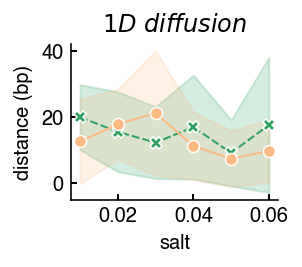

In [45]:
fig=plt.subplots(figsize = (2.2,2.))

#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data_threeD,x='salt',y='distance (bp)',hue='protein'\
              ,linewidth=1,palette=[g3,o2],style="protein",markers=True,ci='sd',hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$1D\ diffusion$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/1D_distance.png",dpi=300,transparent=True)

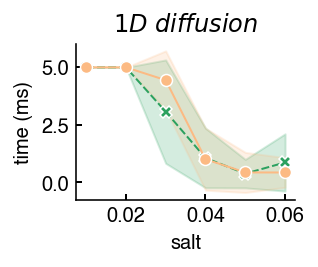

In [44]:
fig=plt.subplots(figsize = (2.2,2.))

#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data_threeD,x='salt',y='time (ms)',hue='protein'\
              ,linewidth=1,palette=[g3,o2],style="protein",markers=True,ci='sd',\
             hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$1D\ diffusion$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/1D_time.png",dpi=300,transparent=True)

In [30]:
S001_data=Dimer.combine_replica(full_dimerS001,'search conformation',0.01)
S002_data=Dimer.combine_replica(full_dimerS002,'search conformation',0.02)
S003_data=Dimer.combine_replica(full_dimerS003,'search conformation',0.03)
S004_data=Dimer.combine_replica(full_dimerS004,'search conformation',0.04)
S005_data=Dimer.combine_replica(full_dimerS005,'search conformation',0.05)
S006_data=Dimer.combine_replica(full_dimerS006,'search conformation',0.06)
R001_data=Dimer.combine_replica(full_dimerR001,'recognition conformation',0.01)
R002_data=Dimer.combine_replica(full_dimerR002,'recognition conformation',0.02)
R003_data=Dimer.combine_replica(full_dimerR003,'recognition conformation',0.03)
R004_data=Dimer.combine_replica(full_dimerR004,'recognition conformation',0.04)
R005_data=Dimer.combine_replica(full_dimerR005,'recognition conformation',0.05)
R006_data=Dimer.combine_replica(full_dimerR006,'recognition conformation',0.06)

2 2
0 0
537 537
1 1
485 485
268 268
552 552
210 210
654 654
377 377
306 306
242 242
284 284
476 476
245 245
0 0
79 79
214 214
154 154
342 342
8 8
781 781
OK!
770 770
768 768
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
531 531
OK!
OK!
646 646
1 1
693 693
2 2
2 2
2 2
568 568
500 500
852 852
254 254
0 0
102 102
29 29
123 123
1 1
30 30
0 0
0 0
1 1
317 317
71 71
2 2
0 0
449 449
418 418
2 2
390 390
1 1
233 233
197 197
43 43
2 2
524 524
0 0
277 277
213 213
454 454
75 75
137 137
114 114
136 136
484 484
401 401
2 2
278 278
8 8
1263 1263
1261 1261
OK!
OK!
1167 1167
1165 1165
1064 1064
OK!
758 758
OK!
OK!
902 902
1270 1270
OK!
OK!
OK!
4 4
129 129
2 2
1 1
2 2
1 1
3 3
2 2
1 1
2 2
1 1
95 95
58 58
42 42
1 1
3 3
2 2
2 2
1 1
1 1
1 1
3 3
10 10
1 1
4 4
1 1
2 2
5 5
87 87
31 31
3 3
40 40
12 12
1 1
1 1
3 3
1 1
0 0
2 2
2 2
1 1
1 1
0 0
1 1
1 1
66 66
24 24
0 0
2 2
1 1
78 78
50 50
3 3
1 1
58 58
2 2
3 3
1 1
1 1
113 113
13 13
8 8
2 2
3 3
4 4
0 0
26 26
299 299
1 1
2 2
71 71
8 8
65 65
0 0
1 1
3 3
1 1
2 2
0 0
0 0
0 0
1 1
1 1
0 

2020 2020
2018 2018
1686 1686
1684 1684
1744 1744
1742 1742
1842 1842
1840 1840
1688 1688
1686 1686
1690 1690
1688 1688
1806 1806
1804 1804
1820 1820
1818 1818
2 2
2 2
2 2
2 2
22 22
1 1
17 17
29 29
43 43
31 31
14 14
2 2
1 1
1 1
1 1
1 1
82 82
32 32
13 13
45 45
163 163
2 2
2 2
0 0
1 1
1 1
8 8
4 4
4 4
2 2
2 2
1 1
2 2
1 1
3 3
4 4
2 2
0 0
9 9
1 1
1 1
1 1
1 1
4 4
2 2
2 2
35 35
25 25
18 18
1 1
3 3
2 2
4 4
3 3
3 3
0 0
16 16
2 2
29 29
5 5
26 26
6 6
4 4
5 5
17 17
19 19
4 4
7 7
30 30
2 2
1 1
1 1
4 4
3 3
1 1
1 1
42 42
0 0
0 0
0 0
1 1
3 3
2 2
2 2
3 3
1 1
1 1
3 3
2 2
0 0
1 1
1 1
1 1
0 0
1 1
2 2
1 1
1 1
2 2
0 0
0 0
0 0
5 5
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
32 32
1 1
0 0
25 25
2 2
3 3
2 2
1 1
1 1
0 0
0 0
0 0
0 0
0 0
7 7
4 4
3 3
0 0
0 0
2 2
1 1
1 1
1 1
1 1
1 1
2 2
13 13
5 5
58 58
3 3
2 2
2 2
10 10
1 1
4 4
3 3
1 1
1 1
1 1
18 18
2 2
2 2
83 83
4 4
36 36
0 0
30 30
9 9
0 0
1 1
0 0
5 5
0 0
66 66
11 11
42 42
1 1
1 1
3 3
4 4
7 7
2 2
2 2
0 0
22 22
5 5
5 5
2 2
3 3
1 1
1 1
2 2
1 1
3 3
6 6
13 13
8 8
2 2


In [46]:
dataS_slides=pd.concat([S001_data[0],S002_data[0],S003_data[0],S004_data[0],S005_data[0],S006_data[0]])
dataS_hops=pd.concat([S001_data[1],S002_data[1],S003_data[1],S004_data[1],S005_data[1],S006_data[1]])
dataS_hops=dataS_hops[(dataS_hops['distance (bp)'] < 25) & (dataS_hops['distance (bp)'] > 2)]
dataS_hops.loc[:,'distance (bp)'] += 2
dataS_flips=([S001_data[2],S002_data[2],S003_data[2],S004_data[2],S005_data[2],S006_data[2]])
dataS_hops_per_ms=([S001_data[3],S002_data[3],S003_data[3],S004_data[3],S005_data[3],S006_data[3]])
dataR_slides=pd.concat([R001_data[0],R002_data[0],R003_data[0],R004_data[0],R005_data[0],R006_data[0]])
dataR_hops=pd.concat([R001_data[1],R002_data[1],R003_data[1],R004_data[1],R005_data[1],R006_data[1]])
dataR_hops=dataR_hops[(dataR_hops['distance (bp)'] < 25) & (dataR_hops['distance (bp)'] > 2)]
dataR_hops.loc[:,'distance (bp)'] += 2
dataR_flips=([R001_data[2],R002_data[2],R003_data[2],R004_data[2],R005_data[2],R006_data[2]])
dataS_hops_per_ms=([R001_data[3],R002_data[3],R003_data[3],R004_data[3],R005_data[3],R006_data[3]])
dimer_slides=dataS_slides.append(dataR_slides)
dimer_hops=dataS_hops.append(dataR_hops)
dimer_slides['speed (bp ms$^{-1}$)']=dimer_slides['distance (bp)']/dimer_slides['time (ms)']
#dimer_slides.dropna(inplace=True)
dimer_hops['speed (bp ms$^{-1}$)']=dimer_hops['distance (bp)']/dimer_hops['time (ms)']

#dimer_hops.dropna(inplace=True)

In [47]:
aggregate_time_distance_sliding_S=dataS_slides.groupby(['salt','replica'], as_index=False).agg({'time (ms)':'sum',\
            'distance (bp)':'sum'})#.groupby('salt', as_index=False).agg({'time (ms)':'mean',\
            #'distance (bp)':'mean'}) 
aggregate_time_distance_sliding_R=dataR_slides.groupby(['salt','replica'], as_index=False).agg({'time (ms)':'sum',\
            'distance (bp)':'sum'})#.groupby('salt', as_index=False).agg({'time (ms)':'mean',\
            #'distance (bp)':'mean'}) 

In [48]:
aggregate_time_distance_hopping_S=dataS_hops.groupby(['salt','replica'], as_index=False).agg({'time (ms)':'sum',\
            'distance (bp)':'sum'})#.groupby('salt', as_index=False).agg({'time (ms)':'mean',\
            #'distance (bp)':'mean'})   
aggregate_time_distance_hopping_R=dataR_hops.groupby(['salt','replica'], as_index=False).agg({'time (ms)':'sum',\
            'distance (bp)':'sum'})#.groupby('salt', as_index=False).agg({'time (ms)':'mean',\
            #'distance (bp)':'mean'})

In [49]:
len(aggregate_time_distance_hopping_R)

38

In [50]:
aggregate_time_distance_hopping_R['conformation']=['recognition conformation' for x in range(38)]
aggregate_time_distance_sliding_R['conformation']=['recognition conformation' for x in range(39)]
aggregate_time_distance_hopping_S['conformation']=['search conformation' for x in range(39)]
aggregate_time_distance_sliding_S['conformation']=['search conformation' for x in range(39)]
aggregate_time_distance_sliding_R['diffusion']=['$sliding$' for x in range(39)]
aggregate_time_distance_hopping_R['diffusion']=['$hopping$' for x in range(38)]
aggregate_time_distance_sliding_S['diffusion']=['$sliding$' for x in range(39)]
aggregate_time_distance_hopping_S['diffusion']=['$hopping$' for x in range(39)]

In [51]:
#aggregate_time_distance_hopping_R['conformation']=['recognition conformation' for x in range(6)]
#aggregate_time_distance_sliding_R['conformation']=['recognition conformation' for x in range(6)]
#aggregate_time_distance_hopping_S['conformation']=['search conformation' for x in range(6)]
#aggregate_time_distance_sliding_S['conformation']=['search conformation' for x in range(6)]
##aggregate_time_distance_sliding_R['diffusion']=['$sliding$' for x in range(6)]
#aggregate_time_distance_hopping_R['diffusion']=['$hopping$' for x in range(6)]
#aggregate_time_distance_sliding_S['diffusion']=['$sliding$' for x in range(6)]
#aggregate_time_distance_hopping_S['diffusion']=['$hopping$' for x in range(6)]

In [52]:
check_total_length_diffusion_modes=pd.concat([aggregate_time_distance_hopping_S,aggregate_time_distance_sliding_S,\
                aggregate_time_distance_hopping_R,aggregate_time_distance_sliding_R])
check_total_length_diffusion_modes[check_total_length_diffusion_modes['conformation']=='search conformation']

,salt,replica,time (ms),distance (bp),conformation,diffusion
0,0.01,1.0,0.11705,28.876667,search conformation,$hopping$
1,0.01,2.0,0.02650,16.845152,search conformation,$hopping$
2,0.01,3.0,0.04285,26.013030,search conformation,$hopping$
3,0.01,4.0,0.06325,38.771212,search conformation,$hopping$
4,0.01,5.0,0.04715,17.398485,search conformation,$hopping$
...,...,...,...,...,...,...
34,0.06,1.0,0.01730,5.103333,search conformation,$sliding$
35,0.06,2.0,0.47455,111.874848,search conformation,$sliding$
36,0.06,3.0,0.89980,150.801818,search conformation,$sliding$
37,0.06,4.0,3.10570,176.081212,search conformation,$sliding$


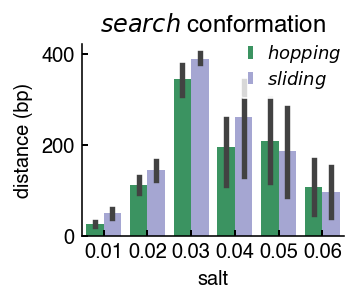

In [147]:
fig=plt.subplots(figsize = (2.6,2.25))
sns.barplot(data=check_total_length_diffusion_modes[check_total_length_diffusion_modes['conformation']=='search conformation']\
            ,y='distance (bp)',hue='diffusion',x='salt',palette=[g3,p2])
#sns.lineplot(data=check_total_length_diffusion_modes[check_total_length_diffusion_modes['conformation']=='search conformation']\
#            ,y='distance (bp)',hue='diffusion',x='salt',palette=[g3,p2])
#palette=[g3,p2]
#plt.legend([],[], frameon=False)
plt.title('$search$ conformation')
plt.legend(title='',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.09),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.tight_layout()
#plt.savefig("/Users/mallu899/Documents/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Total_distance_search_legend.png",dpi=300,transparent=True)


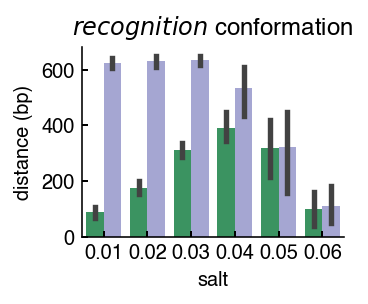

In [148]:
fig=plt.subplots(figsize = (2.6,2.25))

sns.barplot(data=check_total_length_diffusion_modes[check_total_length_diffusion_modes['conformation']=='recognition conformation']\
            ,y='distance (bp)',hue='diffusion',x='salt',palette=[g3,p2])

plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$recognition$ conformation')
plt.tight_layout()
#plt.savefig("/Users/mallu899/Documents/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Total_distance_recognition.png",dpi=300,transparent=True)

In [149]:
check_total_length_diffusion_modes['bp/ms']=check_total_length_diffusion_modes['distance (bp)']/check_total_length_diffusion_modes['time (ms)']

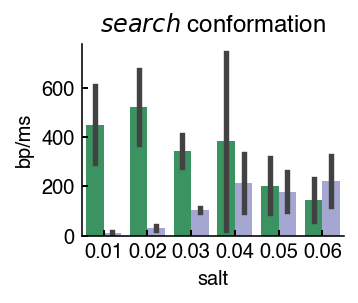

In [150]:
fig=plt.subplots(figsize = (2.6,2.25))

sns.barplot(data=check_total_length_diffusion_modes[check_total_length_diffusion_modes['conformation']=='search conformation']\
            ,y='bp/ms',hue='diffusion',x='salt',palette=[g3,p2],ci='sd')

plt.legend([],[], frameon=False)
plt.title('$search$ conformation')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.tight_layout()

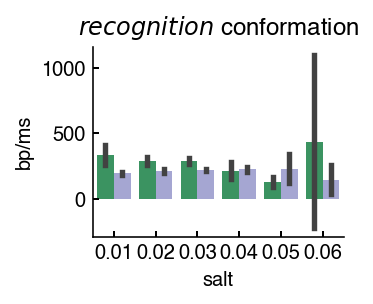

In [151]:
fig=plt.subplots(figsize = (2.6,2.25))

sns.barplot(data=check_total_length_diffusion_modes[check_total_length_diffusion_modes['conformation']=='recognition conformation']\
            ,y='bp/ms',hue='diffusion',x='salt',palette=[g3,p2],ci='sd')
plt.legend([],[], frameon=False)
plt.title('$recognition$ conformation')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.tight_layout()

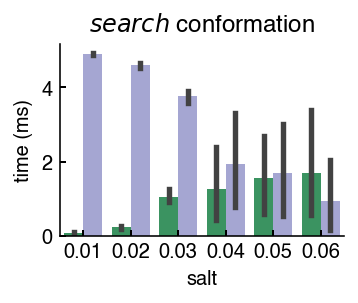

In [152]:
fig=plt.subplots(figsize = (2.6,2.25))

sns.barplot(data=check_total_length_diffusion_modes[check_total_length_diffusion_modes['conformation']=='search conformation']\
            ,y='time (ms)',hue='diffusion',x='salt',palette=[g3,p2])
plt.legend([],[], frameon=False)
plt.title('$search$ conformation')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.tight_layout()
#plt.savefig("/Users/mallu899/Documents/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Total_time_search.png",dpi=300,transparent=True)

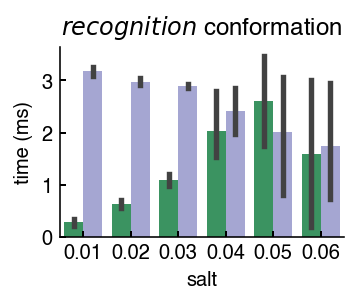

In [153]:
fig=plt.subplots(figsize = (2.6,2.25))

sns.barplot(data=check_total_length_diffusion_modes[check_total_length_diffusion_modes['conformation']=='recognition conformation']\
            ,y='time (ms)',hue='diffusion',x='salt',palette=[g3,p2])
plt.legend([],[], frameon=False)
plt.title('$recognition$ conformation')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.tight_layout()
#plt.savefig("/Users/mallu899/Documents/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Total_time_recognition.png",dpi=300,transparent=True)

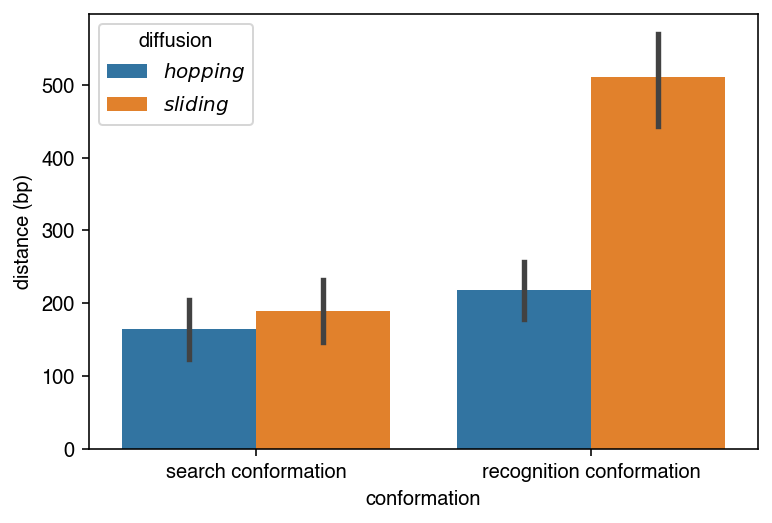

In [154]:
sns.barplot(data=check_total_length_diffusion_modes,y='distance (bp)',x='conformation',hue='diffusion')

In [ ]:
fig=plt.subplots(figsize = (2.2,2.))
#get rid of outliers before plotting
data=dimer_slides[(dimer_slides['distance (bp)'] < 9)]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data,x='salt',y='distance (bp)',hue='protein'\
              ,linewidth=1,palette=[g3,o2],style="protein",markers=True,ci='sd',
             \hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$sliding$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig(\
"/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Sliding_distance.png"\
,dpi=300,transparent=True)

In [79]:
data[data['protein']=='search conformation']

,replica,start_frame,end_frame,start_position,end_position,time (ms),distance (bp),symmetry,flip_sign,protein,salt,speed (bp ms$^{-1}$)
0,1.0,935.0,11894.0,-16.712,-24.038,0.54795,2.220000,symmetric,-25.274,search conformation,0.01,4.051465
0,1.0,11903.0,22463.0,-43.599,-37.944,0.52800,1.713636,symmetric,-19.914,search conformation,0.01,3.245523
0,1.0,22475.0,30419.0,-13.378,-28.123,0.39720,4.468182,symmetric,-24.107,search conformation,0.01,11.249199
0,1.0,30441.0,30890.0,-55.081,-43.188,0.02245,3.603939,symmetric,-27.180,search conformation,0.01,160.531822
0,1.0,30911.0,31309.0,-21.243,-23.781,0.01990,0.769091,symmetric,-25.048,search conformation,0.01,38.647784
...,...,...,...,...,...,...,...,...,...,...,...,...
13,5.0,4346.0,4356.0,12.084,11.229,0.00050,0.259091,asymmetric,NaN,search conformation,0.06,518.181818
14,5.0,4366.0,4422.0,11.580,10.975,0.00280,0.183333,asymmetric,NaN,search conformation,0.06,65.476190
0,5.0,1504.0,1692.0,26.490,36.219,0.00940,2.948182,asymmetric,NaN,search conformation,0.06,313.636364
1,5.0,3138.0,3191.0,10.215,14.137,0.00265,1.188485,asymmetric,NaN,search conformation,0.06,448.484848


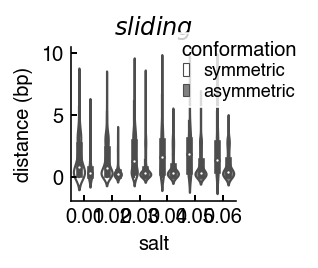

In [83]:
fig=plt.subplots(figsize = (2.2,2.))
#get rid of outliers before plotting
data=dimer_slides[(dimer_slides['distance (bp)'] < 9)]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
#sns.lineplot(data=data[data['protein']=='search conformation'],x='salt',y='distance (bp)',hue='symmetry'\
#              ,linewidth=1,palette=[g3,o2],style="symmetry",markers=True,ci='sd',hue_order=['asymmetric','symmetric'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
sns.violinplot(data=data[data['protein']=='search conformation'],x='salt',y='distance (bp)',hue='symmetry',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
#plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$sliding$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
#plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Sliding_distance.png",dpi=300,transparent=True)

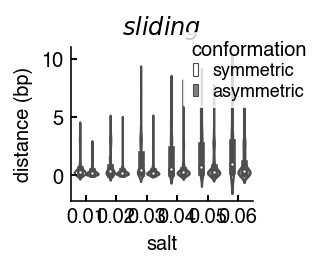

In [84]:
fig=plt.subplots(figsize = (2.2,2.))
#get rid of outliers before plotting
data=dimer_slides[(dimer_slides['distance (bp)'] < 9)]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
#sns.lineplot(data=data[data['protein']=='search conformation'],x='salt',y='distance (bp)',hue='symmetry'\
#              ,linewidth=1,palette=[g3,o2],style="symmetry",markers=True,ci='sd',hue_order=['asymmetric','symmetric'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
sns.violinplot(data=data[data['protein']=='recognition conformation'],x='salt',y='distance (bp)',hue='symmetry',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
#plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$sliding$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()

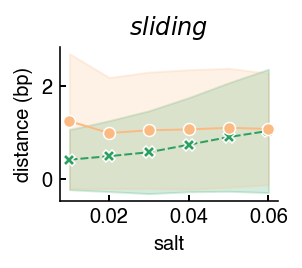

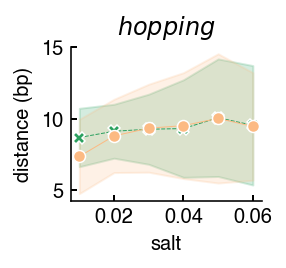

In [53]:
fig=plt.subplots(figsize = (2.2,2.))
#get rid of outliers before plotting
data=dimer_slides[(dimer_slides['distance (bp)'] < 9)]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data,x='salt',y='distance (bp)',hue='protein'\
              ,linewidth=1,palette=[g3,o2],style="protein",markers=True,ci='sd',hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$sliding$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Sliding_distance.png",dpi=300,transparent=True)

fig=plt.subplots(figsize = (2.2,2.))

#sns.stripplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#             palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])
sns.lineplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein'\
,linewidth=0.5,palette=[g3,o2],style="protein",markers=True,ci='sd',hue_order=['recognition conformation','search conformation'])
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.17, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()

plt.title('$hopping$',fontsize=12)
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Hopping_strips.png",dpi=300,transparent=True)

In [186]:
dimer_slides

,replica,start_frame,end_frame,start_position,end_position,time (ms),distance (bp),symmetry,flip_sign,protein,salt,speed (bp ms$^{-1}$)
0,1.0,934.0,6040.0,-15.182,-15.014,0.25530,0.050909,symmetric,-26.804,search conformation,0.01,0.199409
0,1.0,6053.0,9258.0,-16.513,-23.335,0.16025,2.067273,symmetric,-27.879,search conformation,0.01,12.900298
0,1.0,9267.0,9338.0,-19.147,-18.522,0.00355,0.189394,symmetric,-25.739,search conformation,0.01,53.350405
0,1.0,9342.0,11187.0,-17.699,-23.451,0.09225,1.743030,symmetric,-26.515,search conformation,0.01,18.894637
0,1.0,11189.0,11895.0,-43.387,-42.943,0.03530,0.134545,symmetric,-20.529,search conformation,0.01,3.811486
...,...,...,...,...,...,...,...,...,...,...,...,...
0,5.0,282.0,399.0,15.029,22.440,0.00585,2.245758,asymmetric,NaN,recognition conformation,0.06,383.890184
1,5.0,440.0,491.0,22.521,23.858,0.00255,0.405152,asymmetric,NaN,recognition conformation,0.06,158.882947
2,5.0,498.0,505.0,23.649,22.765,0.00035,0.267879,asymmetric,NaN,recognition conformation,0.06,765.367965
3,5.0,519.0,608.0,22.552,24.774,0.00445,0.673333,asymmetric,NaN,recognition conformation,0.06,151.310861


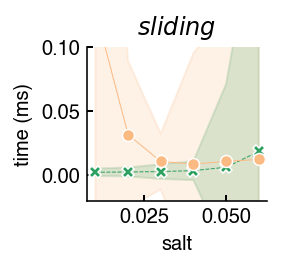

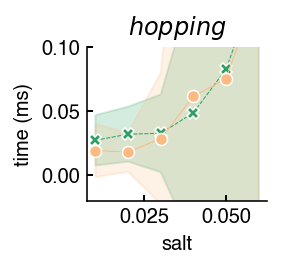

In [76]:
fig=plt.subplots(figsize = (2.2,2.))
#get rid of outliers before plotting
data=dimer_slides[dimer_slides['distance (bp)'] < 20]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data,x='salt',y='time (ms)',hue='protein'\
              ,linewidth=0.5,palette=[g3,o2],style="protein",markers=True,ci='sd',hue_order=['recognition conformation','search conformation'])
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$sliding$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.ylim(-0.02,0.1)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/sliding_time_20bpmax_zoomed.png",dpi=300,transparent=True)

fig=plt.subplots(figsize = (2.2,2.))
#sns.stripplot(data=dimer_hops,x='salt',y='time (ms)',hue='protein',dodge=0.1,linewidth=0.5,\
#              alpha=0.6,palette=[o2,g2],size=3.5)
#sns.violinplot(data=dimer_hops,x='salt',y='time (ms)',hue='protein',dodge=0.1,\
#             palette=[o2,g2])
sns.lineplot(data=dimer_hops,x='salt',y='time (ms)',hue='protein'\
              ,linewidth=0.5,palette=[g3,o2],style="protein",markers=True,ci='sd',hue_order=['recognition conformation','search conformation'])
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.17, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.ylim(-0.02,0.1)
plt.title('$hopping$',fontsize=12)
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/hopping_zoomed.png",dpi=300,transparent=True)

In [172]:
dimer_hops

,replica,start_frame,end_frame,start_position,end_position,time (ms),distance (bp),symmetry,flip_sign,protein,salt,speed (bp ms$^{-1}$)
0,1.0,229.0,950.0,10.828,-17.712,0.03605,10.648485,symmetric,-44.937,search conformation,0.01,295.380994
0,1.0,37285.0,37377.0,-50.534,-58.116,0.00460,4.297576,symmetric,-23.849,search conformation,0.01,934.255599
0,1.0,43859.0,45336.0,-37.519,-63.182,0.07385,9.776667,symmetric,-26.203,search conformation,0.01,132.385466
252,1.0,50600.0,50651.0,-85.374,-92.482,0.00255,4.153939,asymmetric,NaN,search conformation,0.01,1628.995841
0,2.0,32384.0,32787.0,-10.254,9.588,0.02015,8.012727,symmetric,-20.334,search conformation,0.01,397.653959
...,...,...,...,...,...,...,...,...,...,...,...,...
120,3.0,90099.0,90557.0,109.025,94.292,0.02290,6.464545,asymmetric,NaN,recognition conformation,0.06,282.294561
121,3.0,90623.0,90677.0,93.074,83.839,0.00270,4.798485,asymmetric,NaN,recognition conformation,0.06,1777.216611
0,4.0,99.0,226.0,-22.142,-46.903,0.00635,9.503333,asymmetric,NaN,recognition conformation,0.06,1496.587927
15,4.0,84354.0,84436.0,-129.103,-106.875,0.00410,8.735758,asymmetric,NaN,recognition conformation,0.06,2130.672579


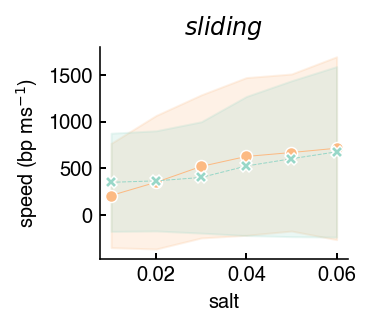

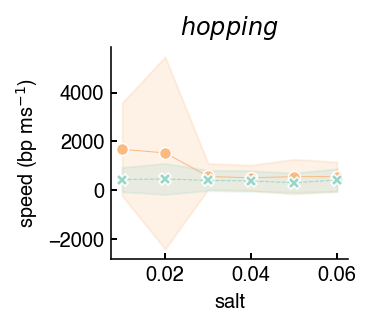

In [188]:
fig=plt.subplots(figsize = (2.7,2.4))
#get rid of outliers before plotting
data=dimer_slides
#sns.boxplot(data=data,x='salt',y='speed (bp ms$^{-1}$)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,palette=[o2,g2])
sns.lineplot(data=data,x='salt',y='speed (bp ms$^{-1}$)',hue='protein'\
              ,linewidth=0.5,palette=[o2,g2],style="protein",markers=True,ci='sd')
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
plt.title('$sliding$',fontsize=12)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()

#plt.savefig("/Users/mallu899/Documents/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Sliding_speed.png",dpi=300,transparent=True)
fig=plt.subplots(figsize = (2.7,2.4))
data=dimer_hops
#sns.boxplot(data=data,x='salt',y='speed (bp ms$^{-1}$)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,palette=[o2,g2])
sns.lineplot(data=data,x='salt',y='speed (bp ms$^{-1}$)',hue='protein'\
              ,linewidth=0.5,palette=[o2,g2],style="protein",markers=True,ci='sd')
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
plt.title('$hopping$',fontsize=12)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
#plt.savefig("/Users/mallu899/Documents/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Hopping_speed.png",dpi=300,transparent=True)


In [103]:
dimer_hops

,replica,start_frame,end_frame,start_position,end_position,time (ms),distance (bp),symmetry,flip_sign,protein,salt,speed (bp ms$^{-1}$)
0,1.0,1418.0,1457.0,-44.189,-45.453,0.00195,0.383030,symmetric,-26.115,search conformation,0.01,196.425796
0,1.0,1486.0,1504.0,-45.057,-47.023,0.00090,0.595758,symmetric,NaN,search conformation,0.01,661.952862
0,1.0,2197.0,2225.0,-24.487,-24.990,0.00140,0.152424,symmetric,NaN,search conformation,0.01,108.874459
0,1.0,3293.0,3330.0,-25.396,-24.780,0.00185,0.186667,symmetric,NaN,search conformation,0.01,100.900901
0,1.0,3411.0,3436.0,-43.100,-46.411,0.00125,1.003333,symmetric,NaN,search conformation,0.01,802.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
19,5.0,5698.0,5731.0,65.829,62.704,0.00165,0.946970,asymmetric,NaN,recognition conformation,0.06,573.921028
20,5.0,5736.0,5744.0,64.480,62.840,0.00040,0.496970,asymmetric,NaN,recognition conformation,0.06,1242.424242
0,5.0,396.0,448.0,19.536,19.330,0.00260,0.062424,asymmetric,NaN,recognition conformation,0.06,24.009324
1,5.0,489.0,523.0,21.548,19.314,0.00170,0.676970,asymmetric,NaN,recognition conformation,0.06,398.217469


In [64]:
d1_S=[d1S001_sum['time (ms)'],d1S002_sum['time (ms)'],d1S003_sum['time (ms)'],\
 d1S004_sum['time (ms)'],d1S005_sum['time (ms)'],d1S006_sum['time (ms)']]
d1_R=[d1R001_sum['time (ms)'],d1R002_sum['time (ms)'],d1R003_sum['time (ms)'],\
 d1R004_sum['time (ms)'],d1R005_sum['time (ms)'],d1R006_sum['time (ms)']]

In [65]:
d1R005_sum['time (ms)']

replica
1    4.39715
2    0.00770
3    4.95470
4    4.80910
5    4.97345
Name: time (ms), dtype: float64

In [66]:
def hopping_frequency_dataframe(data_hops,data_1d,conformation,salt):
    all_hops = [sum(x)/y for x,y in zip(data_hops,data_1d)]
    data={'$f_{hops}$ (ms$^{-1}$)': all_hops,
         'conformation':[conformation for x in range(len(all_hops))],
         'salt':[salt for x in range(len(all_hops))]}
    return(pd.DataFrame(data))
def hopping_frequency_dataframe_salts(data_hops,data_1d,conformation):
    salts=[0.01,0.02,0.03,0.04,0.05,0.06]
    salt_dfs=[]
    for i in range(len(salts)):
        salt_dfs.append(hopping_frequency_dataframe(data_hops[i][3],data_1d[i],conformation,salts[i]))
    all_salts_df=pd.concat([x for x in salt_dfs])
    return(all_salts_df)

In [67]:
hopping_f_S=hopping_frequency_dataframe_salts([S001_data,S002_data,S003_data,\
                                   S004_data,S005_data,S006_data],d1_S,'search')
hopping_f_R=hopping_frequency_dataframe_salts([R001_data,R002_data,R003_data,\
                                   R004_data,R005_data,R006_data],d1_R,'recognition')
hopping_f=pd.concat([hopping_f_S,hopping_f_R])

In [68]:
fe_hops= np.random.normal(loc=4, scale=1, size=8)
exp=pd.DataFrame({'salt':[0.01 for x in range(len(fe_hops))]+[0.02 for x in range(len(fe_hops))]+[0.03 for x in range(len(fe_hops))]+[0.04 for x in range(len(fe_hops))]+[0.05 for x in range(len(fe_hops))]+[0.06 for x in range(len(fe_hops))],'$f_{hops}$ (ms$^{-1}$)':[x for x in fe_hops]*6,'conformation':['experimental' for x in range(len(fe_hops))]+['experimental' for x in range(len(fe_hops))]+['experimental' for x in range(len(fe_hops))]+['experimental' for x in range(len(fe_hops))]+['experimental' for x in range(len(fe_hops))]+['experimental' for x in range(len(fe_hops))]})
#exp=pd.DataFrame({'salt':[0.00 for x in range(len(fe_hops))],'$f_{hops}$ (ms$^{-1}$)':[4,4,4,4,4,4,4,4],'conformation':['experimental' for x in range(len(fe_hops))]})

all_exp=hopping_f.append(exp)

In [69]:
from scipy.stats import zscore

In [70]:
all_exp_no_outlieres

NameError: name 'all_exp_no_outlieres' is not defined

In [71]:
absolute_zscore = np.abs(zscore(all_exp['$f_{hops}$ (ms$^{-1}$)']))
filter_outlierers = (absolute_zscore < 3)
all_exp_no_outlieres= all_exp[filter_outlierers]

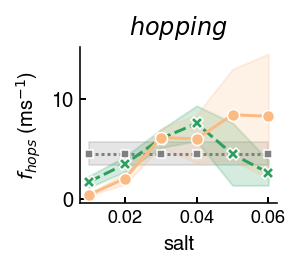

In [74]:
fig=plt.subplots(figsize = (2.2,2.))
g=sns.lineplot(x='salt',y='$f_{hops}$ (ms$^{-1}$)',hue='conformation',data=all_exp_no_outlieres\
            ,palette=['grey',g3,o2],style="conformation",markers=True,ci='sd', hue_order=['experimental','recognition','search'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.title('$hopping$',fontsize=12)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
plt.xticks(fontsize=9)
#b=sns.lineplot(x='salt',y='$f_{hops}$ (ms$^{-1}$)',data=exp,alpha=0.7,color='grey')
g.legend([],[], frameon=False)
#plt.ylim(0.005,17)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/hopping_freq_norm.png",dpi=300,transparent=True)